1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
!wget --no-check-certificate https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

--2022-12-02 21:39:14--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2022-12-02 21:39:15--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2a10777b22786a852347ec13e4.dl.dropboxusercontent.com/cd/0/inline/Bx7XsojxoKF2GsE9HZvUHlQ5HH_fS__xb8_wQicBTPRnI2ogkPqEVdNqS64aXK0s-byWU15Iqn544lMT_v_V5TfSNKEQ2tkT5MPksZycf_8e5LtzED7VXuOc7qVFLX90gTUvaHDX4CG2CdmwDgUVzbXZoiN5grw4zF6VZ1q17Vd3Ng/file# [following]
--2022-12-02 21:39:15--  https://uc2a10777b22786a852347ec13e4.dl.dropboxusercontent.com/cd/0/inline/Bx7XsojxoKF2GsE9HZvUHlQ5HH_fS__xb8_wQicBTPRnI2

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [21]:
import pandas as pd
import numpy as np
file_name = "./data/data_000637.txt"
data = pd.read_csv(file_name, nrows=100000000)
m,n=data.shape
print(data)


        HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0          1     0          123  3869200167        2374      26.0
1          1     0          124  3869200167        2374      27.0
2          1     0           63  3869200167        2553      28.0
3          1     0           64  3869200167        2558      19.0
4          1     0           64  3869200167        2760      25.0
...      ...   ...          ...         ...         ...       ...
720879     1     0           88  3869207129        2151       1.0
720880     1     0           91  3869207129        2254      21.0
720881     1     1          121  3869207129        2503      22.0
720882     1     1          122  3869207129        2511      15.0
720883     1     1          123  3869207129        2515       NaN

[720884 rows x 6 columns]


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [40]:
completeData=pd.read_csv(file_name)
for i in range(m):
    if completeData.iloc[i]['BX_COUNTER']==0:
        zero=i
        maxBX=completeData.iloc[i-1]['BX_COUNTER']
        maxRow=i-1
        
print("MAX BX ",maxBX, "reached at row", maxRow)


MAX BX  3563.0 reached at row 719498


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [41]:
completeData=pd.read_csv(file_name)
completeData['AbsoluteTime']=completeData['TDC_MEAS']*25/30 +completeData['BX_COUNTER']*25 + completeData['ORBIT_CNT']*25*maxBX
s=pd.Series(pd.to_timedelta(completeData['AbsoluteTime'], unit='ns'))
#completeData = completeData.assign(ABSOLUTE_TIME=completeData['BX_COUNTER'].apply(lambda x: x*25) + df['TDC_MEAS'].apply(lambda x: x*25/30) +df['ORBIT_CNT'].apply(lambda x: x*25*3563))
print( completeData['AbsoluteTime'][0:10])

0    3.446490e+14
1    3.446490e+14
2    3.446490e+14
3    3.446490e+14
4    3.446490e+14
5    3.446490e+14
6    3.446490e+14
7    3.446490e+14
8    3.446490e+14
9    3.446490e+14
Name: AbsoluteTime, dtype: float64


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [44]:
print("Hours: ", pd.to_timedelta(completeData['AbsoluteTime'], unit='h'), '\n' '\n' "Minutes: ", pd.to_timedelta(completeData['AbsoluteTime'], unit='m'), '\n' '\n' "Seconds: ", pd.to_timedelta(completeData['AbsoluteTime'], unit='s') )

Hours:  0        -4021 days +11:13:41.752303104
1        -4021 days +12:02:26.752303104
2        -3835 days +23:51:11.752303104
3        -3830 days +21:21:11.752303104
4        -3619 days +12:21:11.752303104
                      ...              
720879      937 days 08:39:12.896557568
720880     1045 days 08:20:27.896557568
720881     1304 days 18:09:12.896557568
720882     1312 days 20:20:27.896557568
720883                              NaT
Name: AbsoluteTime, Length: 720884, dtype: timedelta64[ns] 

Minutes:  0        -85469 days +09:33:24.212051072
1        -85469 days +09:34:12.962051072
2        -85466 days +12:10:01.712051072
3        -85466 days +14:07:31.712051072
4        -85462 days +02:22:31.712051072
                       ...              
720879   -81828 days +10:18:24.292947840
720880   -81826 days +05:30:05.542947840
720881   -81822 days +13:15:54.292947840
720882   -81822 days +16:30:05.542947840
720883                               NaT
Name: AbsoluteTime, Length: 72

5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [46]:
completeData.groupby('TDC_CHANNEL').max()[-3:]


,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS,AbsoluteTime
TDC_CHANNEL,,,,,,
137,1,1,3869207126,3535,15.0,3.446496e+14
138,1,1,3869207126,3535,8.0,3.446496e+14
139,1,1,3869207129,3563,0.0,3.446496e+14


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [47]:
count = completeData[(df_complete['TDC_CHANNEL'])!=0]
uniqueCount = len(set(count.ORBIT_CNT))
uniqueCount

6959

7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [50]:
count1 =completeData[(completeData['TDC_CHANNEL'])==139]
count139 = len(set(count1.ORBIT_CNT))
count139

6934

8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [54]:
serie1 = pd.Series(data=completeData['BX_COUNTER'], index=completeData['TDC_CHANNEL'])
serie2 = pd.Series(data=completeData['ORBIT_CNT'], index=completeData['TDC_CHANNEL'])
print(serie1,serie2)

TDC_CHANNEL
123    1725
124    1882
63      282
64      288
64      288
       ... 
88     1505
91     1503
121    1726
122    1726
123    1725
Name: BX_COUNTER, Length: 720884, dtype: int64 TDC_CHANNEL
123    3869200168
124    3869200168
63     3869200168
64     3869200168
64     3869200168
          ...    
88     3869200168
91     3869200168
121    3869200168
122    3869200168
123    3869200168
Name: ORBIT_CNT, Length: 720884, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

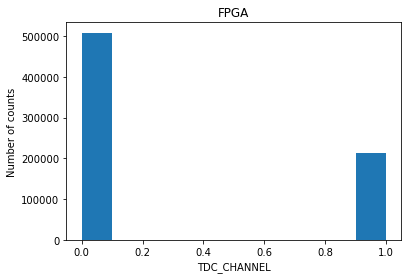

In [66]:
import matplotlib.pyplot as plt
plt.hist(completeData['FPGA'])
plt.title('FPGA')
plt.xlabel('TDC_CHANNEL')
plt.ylabel('Number of counts')
plt.show()